# PROJECT 1: FINDING LANE LINES
**Objective:**
Detect and identify the lane lines on given set of videos.
There are 3 videos for which we have to identify the lanes.
*   solidWhiteRight.mp4
*   solidYellowLeft.mp4  
*   challenge.mp4

The challenge.mp4 is the video bonus challenge.

The goal is to connect, average and extrapolate line segments to get output like shown below:

<img src="images/laneLines_thirdPass.jpg">


#### Importing the libraries

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


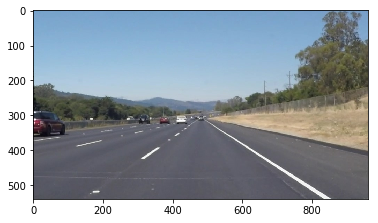

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)
# if you wanted to show a single color channel image called 'gray',
#for example, call as plt.imshow(gray, cmap='gray')

In [3]:
def display_image(input_image,output_image):
    fig = plt.figure()
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(input_image, cmap='gray')
    a.set_title('Input image')

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(output_image, cmap='gray')
    imgplot.set_clim(0.0, 0.7)
    a.set_title('Output image')
    return a

Some OpenCV functions that might be useful for this project are:

*   cv2.inRange() for color selection
*   cv2.fillPoly() for regions selection
*   cv2.line() to draw lines on an image given endpoints
*   cv2.addWeighted() to coadd / overlay two images cv2.cvtColor() to grayscale or change 
*   color cv2.imwrite() to output images to file
*   cv2.bitwise_and() to apply a mask to an image

Check out the   [OpenCV documentation](https://docs.opencv.org/2.4/doc/tutorials/tutorials.html) to learn about these and discover even more awesome functionality!

**Project Implementation Breakdown:**

To solve this problem we first need to understand the computer vision fundamentals.
The below mentioned topics will help us in finding the lane lines. 
1.	Color Selection.
2.	Grayscaling
3.	Gaussian smoothing
4.	Canny Edge Detection.
5.	Region of Interest Mask.
6.	Implementing a Hough Transform on Edge Detected Image.

We will now look into the topics individually to understand them in detail.


**1. Color Selection**

For most of the sections we will be using this image to perform the required transformations and visualize the output of each step.

<img src="images/Test_image.jpg">

To identify lane lines on the road features like color, shape, orientation and position of the image are needed. Lane markings are generally painted as long lines on the road, which can make them relatively easy to detect by their shape. When the car is pointed straight down the road, the lane lines most often appear slanting steeply toward the middle from the left and right sides of an image. 

Given that a camera mounted on a car will be in a fixed position, the lane lines will tend to always appear in the same general region of an image from that camera.
The lanes lines are white colored as shown in the picture. Now our first task is to select the white pixels in the image. To do that we first need to understand what color actually means in case of digital images.
<img src="images/RGB1.png">
Digital images are usually made up of stacks of three images, one each for red green and blue color. These are images are called as color channels. Each of the color channels contains pixel values ranging from 0 to 255, where Zero is the darkest value and 255 is the brightest value.

Pure white color in our combined red + green + blue [R, G, B] color channels would be [255,255,255].


In [4]:
image = mpimg.imread('images/color_selection_ip.jpg')

In [5]:
#Create a copy of the image

color_select = np.copy(image)

#np.copy : Returns an array copy of the given object

In [6]:
# Define color selection criteria
# Modify the below variables in the cell to make the required color selection
red_threshold   = 200
green_threshold = 200
blue_threshold  = 200

In [7]:
# Create rgb_threshold which contains the array of red_threshold,green_threshold and blue_threshold
rgb_threshold = [red_threshold,green_threshold,blue_threshold]

In [8]:
# Do a boolean or with the "|" character to identify
# pixels below the thresholds
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])


In [9]:
color_select[thresholds] = [0,0,0]

Text(0.5,1,'Output image')

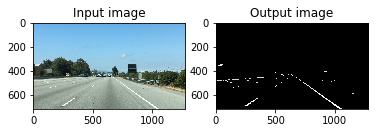

In [10]:
# Display the image                 
#plt.imshow(color_select)
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(image)
a.set_title('Input image')

a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(color_select)
imgplot.set_clim(0.0, 0.7)
a.set_title('Output image')

You can play around modifying the threshold values to see the difference they make on the given image.

**2. Grayscaling**

Apply the Grayscale transform on the image. The below function will return an image with only one color channel.
Feel free to check out this post on why  [grayscale transformation](https://www.quora.com/In-image-processing-applications-why-do-we-convert-from-RGB-to-Grayscale) is important.

In [11]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

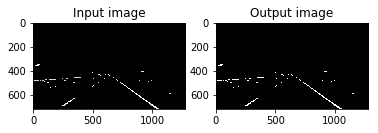

In [12]:
# View the output image
gray = grayscale(color_select)
#plt.imshow(gray, cmap='gray')
display_image(color_select,gray)

**3. Gaussian smoothing**

In image processing, a Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. 

It is a widely used effect in graphics software, typically to reduce image noise and reduce detail.

Since the Fourier transform of a Gaussian is another Gaussian, applying a Gaussian blur has the effect of reducing the image's high-frequency components; a Gaussian blur is thus a low pass filter.

In [13]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

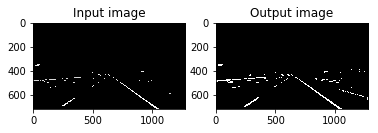

In [14]:
# Defining a kernel size and apply dilation & Gaussian smoothing
kernel_size = 3
dilated_gray = cv2.dilate(gray, (kernel_size, kernel_size))
blur_gray = cv2.GaussianBlur(dilated_gray,(kernel_size, kernel_size),0)  
#plt.imshow(blur_gray, cmap='gray')
display_image(gray,blur_gray)

Gaussian smoothing is commonly used with edge detection. Most edge-detection algorithms are sensitive to noise; the 2-D Laplacian filter, built from a discretization of the Laplace operator, is highly sensitive to noisy environments. 

Using a Gaussian Blur filter before edge detection aims to reduce the level of noise in the image, which improves the result of the following edge-detection algorithm. 

This approach is commonly referred to as Laplacian of Gaussian, or LoG filtering.

#### 4. Canny Edge Detection

The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986.
Canny also produced a computational theory of edge detection explaining why the technique works.

Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. 
It has been widely applied in various computer vision systems. 
Canny has found that the requirements for the application of edge detection on diverse vision systems are relatively similar. 

Thus, an edge detection solution to address these requirements can be implemented in a wide range of situations. The general criteria for edge detection include:

1. Detection of edge with low error rate, which means that the detection should accurately catch as many edges shown in the image as possible
2. The edge point detected from the operator should accurately localize on the center of the edge.
3. A given edge in the image should only be marked once, and where possible, image noise should not create false edges.

**Process of Canny edge detection algorithm**

The Process of Canny edge detection algorithm can be broken down to 5 different steps:

1. Apply Gaussian filter to smooth the image in order to remove the noise
2. Find the intensity gradients of the image
3. Apply non-maximum suppression to get rid of spurious response to edge detection
4. Apply double threshold to determine potential edges
5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

In [15]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

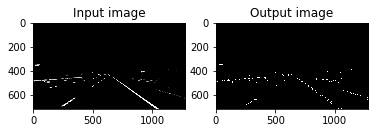

In [16]:
# Defining parameters for Canny edge detection
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)  
display_image(blur_gray,edges)

**5.	Region of interest mask**

Now we have seen that with a simple color selection we have managed to eliminate almost everything in the image except the lane lines.

At this point, however, it would still be tricky to extract the exact lines automatically, because we still have some other objects detected around the periphery that aren't lane lines.

In this case, let’s assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, we’ll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

In the code below, the variables left_bottom, right_bottom, and apex represent the vertices of a triangular region that we would like to retain for my color selection, while masking everything else out. Here we are using a triangular mask to illustrate the simplest case, but later we’ll use a quadrilateral, and in principle, you could use any polygon.

Next, we will take the values of red_threshold, green_threshold, and blue_threshold  provided earlier and now we need to modify left_bottom, right_bottom, and apex to represent the vertices of a triangle identifying the region of interest in the image. When we run the code, our output result will be several images. 


Tweak the vertices until our output looks like the examples shown below.

<img src="images/roi.png">


In [17]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

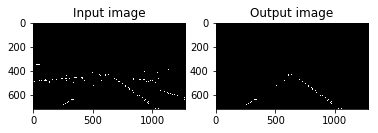

In [18]:
# Defining the region of interest
imshape = image.shape
h,w = imshape[:2]

vertex = 9*h/16
wstep = w/32
hstep = h/32

tbl = (wstep,h)
ttm = (w/2,vertex)
tbr = (w-wstep,h)

bbr = (w-7*wstep,h)
btm = (w/2,vertex+hstep)
bbl = (7*wstep,h)

vertices = np.array([[tbl, ttm, tbr, bbr, btm, bbl]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
display_image(edges,masked_edges)

#### 6. Hough Transform on Edge Detected Image

The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing.

The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in a parameter space, from which object candidates are obtained as local maxima in a so-called accumulator space that is explicitly constructed by the algorithm for computing the Hough transform.

In automated analysis of digital images, a subproblem often arises of detecting simple shapes,
such as straight lines, circles or ellipses. 

In many cases an edge detector can be used as a pre-processing stage to obtain image points or image pixels
that are on the desired curve in the image space. 

Due to imperfections in either the image data or the edge detector, however, there may be missing points 
or pixels on the desired curves as well as spatial deviations between the ideal line/circle/ellipse and the noisy edge points as they are obtained from the edge detector. 

For these reasons, it is often non-trivial to group the extracted edge features to an appropriate set of lines, circles or ellipses. 

The purpose of the Hough transform is to address this problem by making it possible to perform groupings of edge points into object candidates by performing an explicit voting procedure over a set of parameterized image objects

The simplest case of Hough transform is detecting straight lines. In general, the straight line y = mx + b can be represented as a point (b, m) in the parameter space. However, vertical lines pose a problem. They would give rise to unbounded values of the slope parameter m

<img src="images/Hough_transform.PNG">



$$
r = x\cos \theta + y\sin \theta
$$

where $ r$ is the distance from the origin to the closest point on the straight line,and $ \theta$ is the angle between the $ x$ axis and the line connecting the origin with that closest point.

Refer this [blog](http://aishack.in/tutorials/hough-transform-basics/) to learn more about the Hough transform

In [19]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines

In [20]:
# Defining the Hough transform parameters    
# Distance resolution in pixels of the grid
rho = 1        
# Angular resolution in radians of the grid
theta = np.pi/180   
# Intersections in Hough grid cell
threshold = 40  
# Minimum number of pixels making up a line
min_line_length = 20 
# Maximum gap in pixels between connectable line segments
max_line_gap = 40    

lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap) 


In [21]:
def draw_lines(img, lines, ytop, ybot, color=[255, 0, 0], thickness=10, ls=-0.65, rs=0.65, dm=0.15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global frame_no
    global left_lane
    global right_lane
    
    # Segmenting the lines
    left_lines, right_lines = line_segment(lines, ls, rs, dm)

    # average the lines, average with prior lane, and draw
    if left_lines.size is not 0:
        if frame_no is 0:
            left_lane = avg_lines(img, left_lines, ytop, ybot)
        else:
            prior_left_lane = left_lane
            new_left_lane = avg_lines(img, left_lines, ytop, ybot)
            left_lane = np.round(np.average(np.vstack((prior_left_lane, new_left_lane)), axis=0)).astype(int)
    if right_lines.size is not 0:
        if frame_no is 0:
            right_lane = avg_lines(img, right_lines, ytop, ybot)
        else:
            prior_right_lane = right_lane
            new_right_lane = avg_lines(img, right_lines, ytop, ybot)
            right_lane = np.round(np.average(np.vstack((prior_right_lane, new_right_lane)), axis=0)).astype(int)
            
    # draw the lanes; if a new lane was not properly calculated, use the prior lane
    x1, y1, x2, y2 = left_lane
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    x1, y1, x2, y2 = right_lane
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [22]:
def line_segment(lines, ls, rs, dm):
    
    global frame_no
    # Set slope based on the last lane
    if frame_no is not 0: 
        ls = (left_lane[3] - left_lane[1])/(left_lane[2] - left_lane[0])
        rs = (right_lane[3] - right_lane[1])/(right_lane[2] - right_lane[0])
    # Calculate slopes of all lines
    # m = (y2 - y1)/(x2 - x1)
    slopes = (lines[:,:,3] - lines[:,:,1])/(lines[:,:,2] - lines[:,:,0])

    # lane selector
    left = [(slopes<ls+dm) & (slopes>ls-dm)] 
    right = [(slopes<rs+dm) & (slopes>rs-dm)]
    
    return lines[left], lines[right]


In [23]:
def avg_lines(img, lines, ytop, ybot):    
    """
    This function takes multiple line segments and computes their averages.
    Returns endpoints of the average lines at the boundaries of the image.
    """
    # Average slope
    m = np.average((lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0]))
    # Average of x values
    x = np.average(np.concatenate((lines[:,0], lines[:,2]))) 
    # Average of y values
    y = np.average(np.concatenate((lines[:,1], lines[:,3]))) 
    b = y - m*x 
    
    # Calculate the x-values at the top and bottom of the lines
    xtop = np.round((ytop-b)/m).astype(int)
    xbot = np.round((ybot-b)/m).astype(int)
    return [xtop, ytop, xbot, ybot]


In [24]:
frame_no = 0
left_lane = [0,0,0,0]
right_lane = [0,0,0,0]
lanes = np.zeros((h, w, 3), dtype=np.uint8)
ytop = np.round(19*h/32).astype(int)
ybot = h
draw_lines(lanes, lines, ytop, ybot) 

In [25]:
# Draw the lines on the edge image
# α * img1 + β * img2 + λ
α, β, λ = 1, 1.5, 0 
image_lanes = cv2.addWeighted(image, α, lanes, β, λ) 

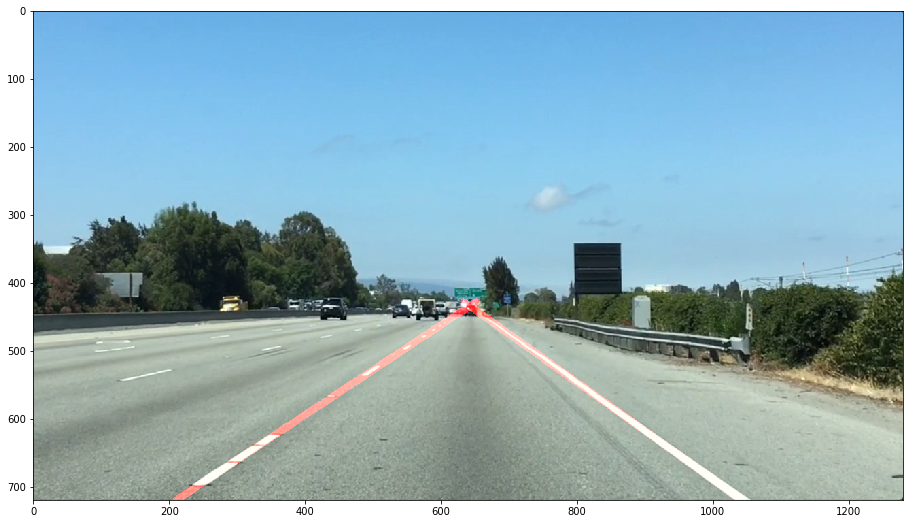

In [26]:
plt.figure(figsize=(16,9))
plt.imshow(image_lanes)

#### Test Images
Build the pipeline to work on the images in the directory "test_images"
We should make sure our pipeline works well on these images before you try the videos.



In [27]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

#### Build a Lane Finding Pipeline

Build the pipeline and run our solution on all test_images. Make copies into the test_images_output directory, and we can use the images in our writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

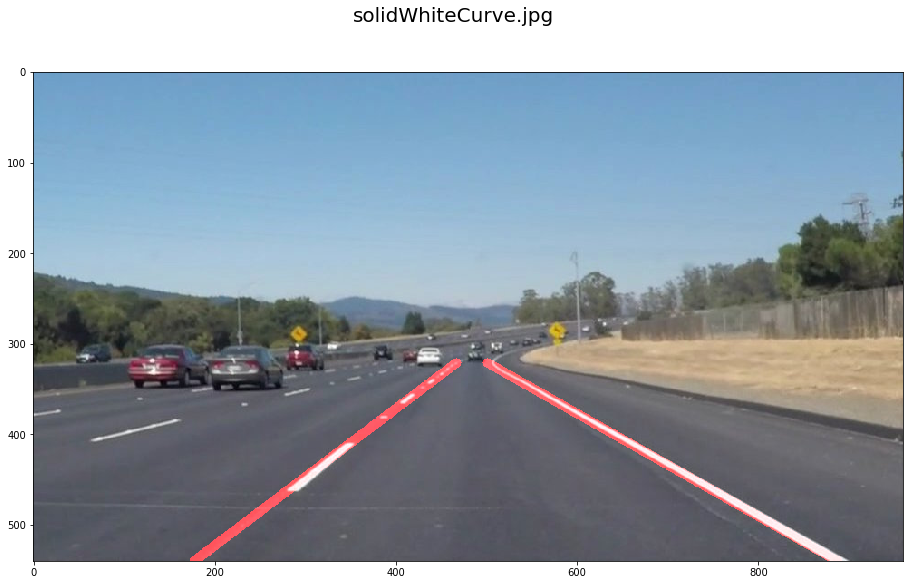

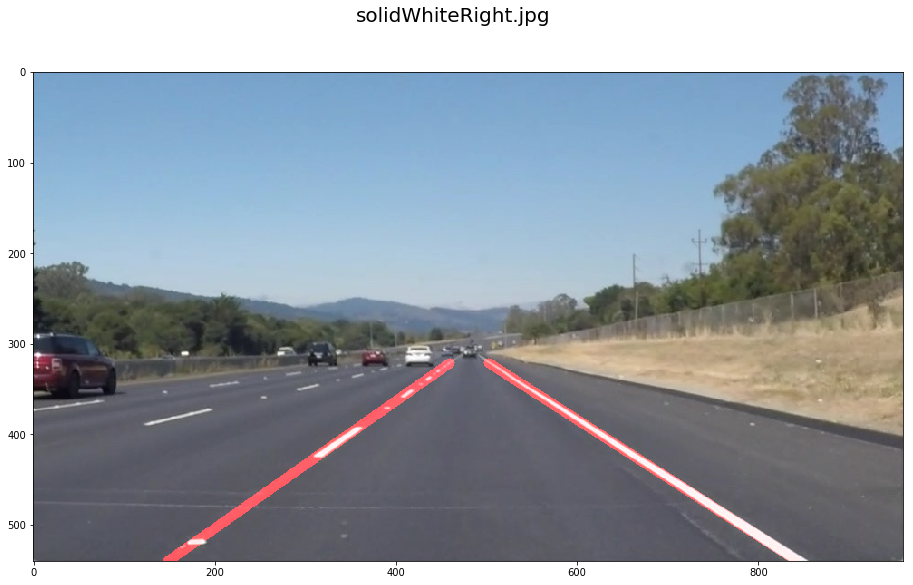

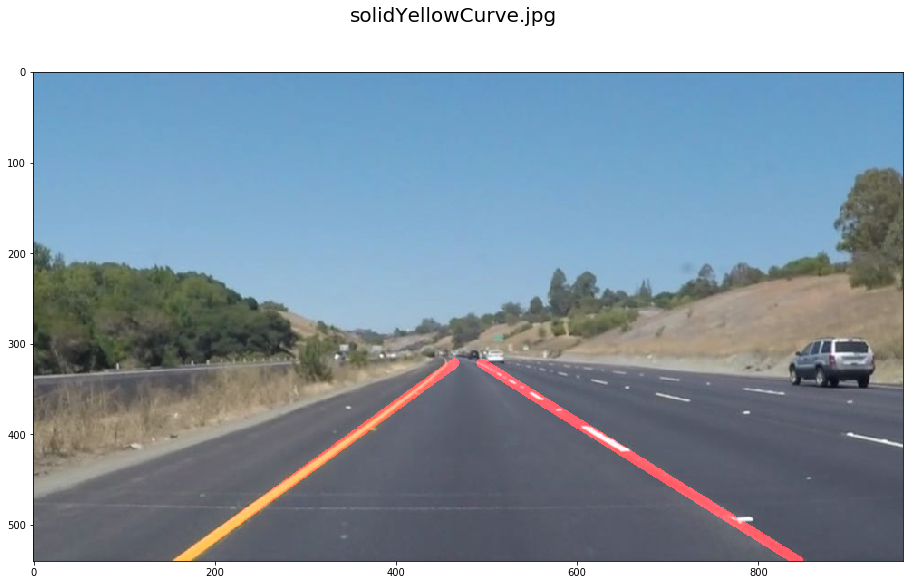

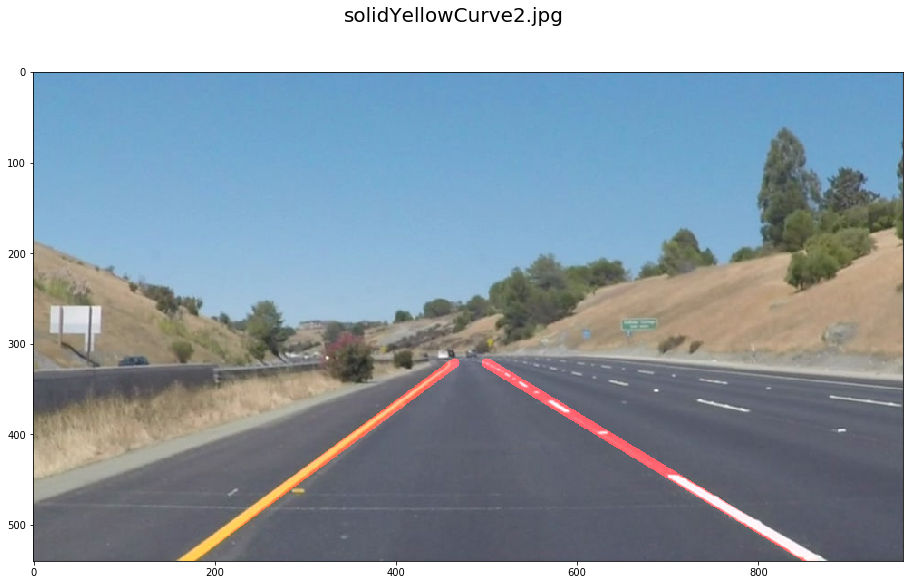

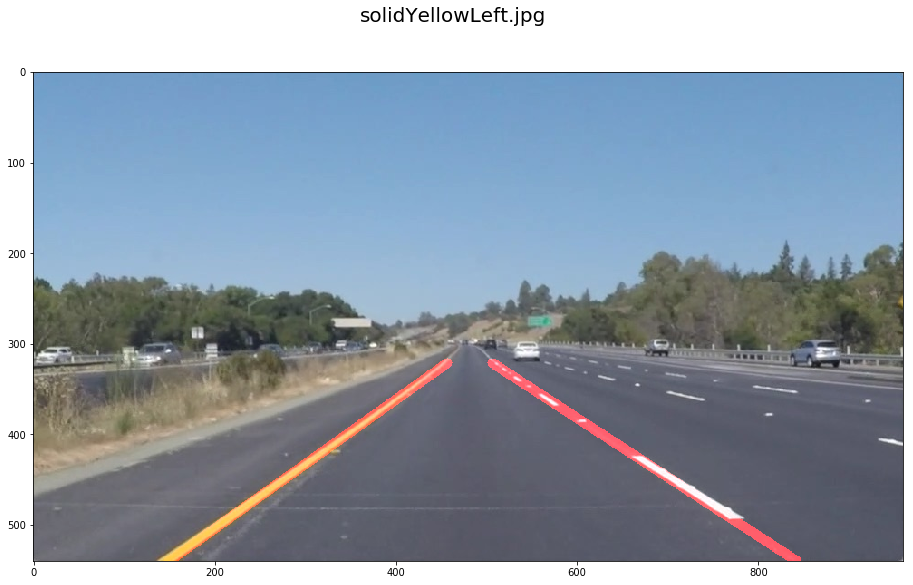

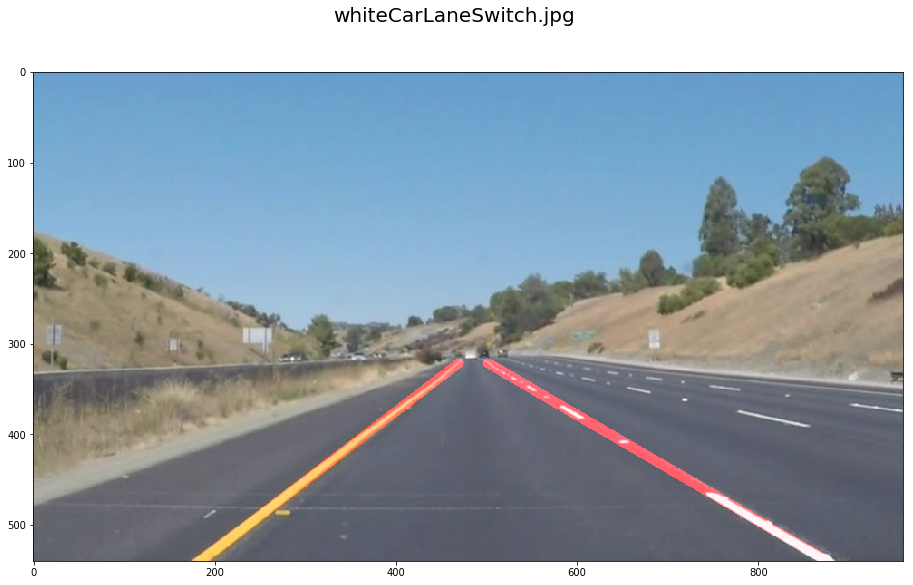

In [28]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

# Read in and grayscale the image
img_filenames = os.listdir("test_images/")
for img_filename in img_filenames:
    image = mpimg.imread('test_images/'+img_filename)    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)    

    frame_no = 0
    left_lane = [0,0,0,0]
    right_lane = [0,0,0,0]

    # Defining a kernel size and apply dilation & Gaussian smoothing
    kernel_size = 3
    dilated_gray = cv2.dilate(gray, (kernel_size, kernel_size))
    blur_gray = cv2.GaussianBlur(dilated_gray,(kernel_size, kernel_size),0)    

    # Defining parameters for Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)  

    # Defining the region of interest
    imshape = image.shape
    h,w = imshape[:2]

    vertex = 9*h/16
    wstep = w/32
    hstep = h/32

    tbl = (wstep,h)
    ttm = (w/2,vertex)
    tbr = (w-wstep,h)

    bbr = (w-7*wstep,h)
    btm = (w/2,vertex+hstep)
    bbl = (7*wstep,h)

    vertices = np.array([[tbl, ttm, tbr, bbr, btm, bbl]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
   

    # Defining the Hough transform parameters
    
    # Distance resolution in pixels of the grid
    rho = 1        
    # Angular resolution in radians of the grid
    theta = np.pi/180   
    # Intersections in Hough grid cell
    threshold = 40  
    # Minimum number of pixels making up a line
    min_line_length = 20 
    # Maximum gap in pixels between connectable line segments
    max_line_gap = 40    
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)     

    lanes = np.zeros((h, w, 3), dtype=np.uint8)
    ytop = np.round(19*h/32).astype(int)
    ybot = h
    draw_lines(lanes, lines, ytop, ybot)  

    # Draw the lines on the edge image
    # α * img1 + β * img2 + λ
    α, β, λ = 1, 1.5, 0 
    image_lanes = cv2.addWeighted(image, α, lanes, β, λ) 
    
    dirName = 'test_images_output'
    # Create target Directory if don't exist
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")   

    plt.figure(figsize=(16,9))
    plt.imshow(image_lanes)
    plt.suptitle(img_filename, fontsize=20)
    plt.imsave('test_images_output/'+img_filename, image_lanes)

#### Test on Videos
You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

* solidWhiteRight.mp4
* solidYellowLeft.mp4

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Defining the region of interest
    imshape = image.shape
    h,w = imshape[:2]
    wstep = w/64
    
    global frame_no
    # Defining the beginning Region of interest, i.e, first frame of the video
    if frame_no is 0: 
        
        vertex = 8*h/16
        wstep = w/32
        hstep = h/16

        tbl = (wstep,h)
        ttm = (w/2,vertex)
        tbr = (w-wstep,h)

        bbr = (w-7*wstep,h)
        btm = (w/2,vertex+hstep)
        bbl = (7*wstep,h)

        vertices = np.array([[tbl, ttm, tbr, bbr, btm, bbl]], dtype=np.int32)
    # Other frames, use previous line to define an ROI    
    else: 
        
        global left_lane
        xtop, ytop, xbot, ybot = left_lane
        llb = (xbot-wstep, ybot)
        lrb = (xbot+wstep, ybot)
        llt = (xtop-wstep, ytop)
        lrt = (xtop+wstep, ytop)

        global right_lane
        xtop, ytop, xbot, ybot = right_lane
        rlb = (xbot-wstep, ybot)
        rrb = (xbot+wstep, ybot)
        rlt = (xtop-wstep, ytop)
        rrt = (xtop+wstep, ytop)

        vertices = np.array([[llb, llt, rrt, rrb, rlb, rlt, lrt, lrb]], dtype=np.int32)

    # Selecting yellow pixels
    yellow_low = np.array([120,100,20])
    yellow_high = np.array([255,250,100])
    # Select the yellow pixels in the video
    yellow = cv2.inRange(image, yellow_low, yellow_high) 
    # mask the yellow region
    masked_yellow = region_of_interest(yellow, vertices) 
    dilate_kernel = np.ones((3,3),np.uint8) 
    masked_dilated_yellow = cv2.dilate(masked_yellow, dilate_kernel)
    
    # Kernel size and apply Gaussian smoothing
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Set the yellow pixels to white
    gray[masked_dilated_yellow==255] = 255 
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define parameters for Canny edge detections
    low_threshold = 100
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges, vertices)
    
    # Apply Hough on detected edges
    # Distance resolution in pixels of the grid
    rho = 1     
    # Angular resolution in radians of the grid
    theta = np.pi/180   
    # Iintersections in the grid
    threshold = 40    
    # Minimum number of pixels making up a line
    min_line_length = 20 
    # Maximum gap in pixels between connectable line segments
    max_line_gap = 40   
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    lanes = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    ytop = np.round(19*h/32).astype(int)
    ybot = h
    if lines is not None:
        if frame_no is 0:
            draw_lines(lanes, lines, ytop, ybot, ls=-0.65, rs=0.65, dm=0.15)
        else:
            draw_lines(lanes, lines, ytop, ybot)

        # Draw the lines on the edge image
        # α * img1 + β * img2 + λ
        α, β, λ = 1, 1.5, 0 
        image_lanes = cv2.addWeighted(image, α, lanes, β, λ) 
    else:
        image_lanes = image
    
    # increment the frame counter
    frame_no = frame_no + 1
        
    return image_lanes 

Let's try the one with the solid white lane on the right first ...

In [31]:
dirName = 'test_videos_output'
# Create target Directory if don't exist
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")  
    
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:10<00:00, 21.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**Improve the draw_lines() function**

At this point, if we were successful with making the pipeline and tuning parameters, we probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)? Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. See an example of the result you're going for in the video "P1_example.mp4".

Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [33]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:38<00:00, 17.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 40 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

**Optional Challenge**
Try the lane finding pipeline on the video below. Does it still work? Can you figure out a way to make it more robust? If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [35]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('challenge.mp4').subclip(0,5)
# frame counter is initializaed to 0
frame_no = 0 
left_lane = [0,0,0,0]
right_lane = [0,0,0,0]
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 99%|█████████▉| 125/126 [00:09<00:00, 12.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 13.2 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))